
# Deep Learning Homework 6 (Spring 2022)

This code is provided for Deep Learning class (CS 482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, and Keith Harrigian.


### Imports

In [2]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [3]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

# import EarlyStopping
# from pytorchtools import EarlyStopping

In [4]:
gpu_boole = torch.cuda.is_available()

# Problem 1: Unsupervised Pre-training

(a) Train a segmentation network using the frames in the ‘/segmentation/train’ folder.
Please complete the DICE score function to evaluate your model, and write from scratch
a DICE loss function as your network loss (Read more about the DICE score here).
(Hint: You need to convert the grey-scale label mask to one-hot encoding of the label
and then calculate the DICE score for each label). Please train the network until
convergence (should take around 30 min) using the default provided hyperparameters
and provide a figure of training loss and validation loss w.r.t. epochs (in a single figure).
Please report your performance (DICE score) on the test dataset, you should expect a
DICE score > 0.5.

(b) Introduce meaningful data augmentation (e.g. vertical and horizontal flips) and train
the network until convergence using the same hyperparameters as (a). Please plot
the training loss and validation loss on a single figure again and report test dataset
performance, you should expect a DICE score > 0.6.

(c) Train on the colorization task using frames from the ‘/colorization/train_cor’ folder.
Use hyperparameters that seem reasonable (based on your previous experiments) and
mean squared error as your loss function. Please provide a figure of training loss w.r.t.
epochs until your model converges. Then save your model to initialize the network for
the next task.

(d) Load the colorization pre-trained model and start training for the segmentation task
using the frames in the ‘/segmentation/train’ folder. Make sure you are using the
same hyperparameters as you did in the former task, and please clearly state them in
your report. Plot the figure of training loss and validation loss. Report test dataset
performance. Do you see a difference with the former result in (b)?

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

In [5]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

### Data Paths

In [6]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "/content/gdrive/MyDrive/HW6_data"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [7]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 8 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """
        
        """
        ## Load Image and Parse Properties
        img_name = str(idx) + '_input.jpg'
        mask_name = str(idx) + '_mask.png'

        #The images are transformed into NumPy array
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if len(mask.shape) == 2:
            h, w  = mask.shape
        elif len(mask.shape) == 3:
            h, w, c = mask.shape

        ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            #if the mask has 3 dimension use this code
            # new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
            #if the mask has 1 dimension use the code below
            new_mask[:, :, idx] = mask == self.mask_value[idx]
        ## Transform image and mask
        if self.transform:
            img, mask = self.img_transform(img, new_mask)
        # ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """
        
        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)

        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [8]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self,n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        #8 categories
        self.out = nn.Sequential(
            nn.Conv2d(32, 8, kernel_size = 1),
            nn.Sigmoid(),    #returns probabilities for each pixel
        )

        # self.out = nn.Sequential(
        #     # nn.Sigmoid(),
        #     nn.Conv2d(32, 8, kernel_size = 1, stride=1, padding=0, bias=True),
        #     nn.Softmax(dim=1)
        # )

    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        out = self.out(conv1m_out)
        return out


### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [ ]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    dice_classes = np.zeros(n_classes)
    n = prediction.size(0) * prediction.size(1)
    if gpu_boole:
        prediction = prediction.cpu()
    prediction = prediction.view(-1, n).detach().numpy()
    #calculate dice score for each class
    for cl in range(n_classes):
        y = target[cl]
        y = y.view(-1,n)  #ground truth of the class in the image
        if gpu_boole:
            y = y.cpu()
        y = y.detach().numpy()
        TP = 0
        FP = 0
        FN = 0
        for i in range(n):
            t = y[0][i]
            pred = prediction[0][i]
            if t == 1 and pred == cl:       #ground truth: TRUE and prediction: TRUE
                TP += 1
            elif t == 0 and pred == cl:     #ground truth: FALSE and prediction: TRUE
                FP += 1
            elif t == 1 and pred != cl:     #ground truth: TRUE and prediction: FALSE
                FN += 1
        #dice score for each class
        if (TP + FN == 0) and (FP == 0):            #When there is no grount truth of the class in this image           
            dice_classes[cl] = 1                    #Give 1 dice score if False Positive pixel number is 0, 
        elif (TP + FN == 0) and (FP != 0):             
            dice_classes[cl] = 0                    #give 0 dice score if False Positive pixel number is not 0 (> 0).
        else:
            dice_classes[cl] = (2 * TP) / ((TP + FP) + (TP + FN))
    return dice_classes.mean()



def dice_score_dataset(model, dataloader, num_classes, use_gpu=False):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        batch_size = prediction.shape[0]
        for i in range(batch_size):
            scores[idx] += dice_score_image(prediction[i], target[i], n_classes)
        scores[idx] /= batch_size
        # scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


## TODO: Implement DICE loss, 
#  It should conform to to how we compute the dice score.
class DICELoss(nn.Module):
    def __init__(self):
        super(DICELoss, self).__init__()
    
    def forward(self, prediction, target):
        n_classes = target.shape[1]
        loss = 0
        for i in range(n_classes):
            p = prediction[:,i]
            t = target[:,i]
            batch_size = t.shape[0]
            pflat = p.view(batch_size, -1)
            tflat = t.view(batch_size, -1)
            #dice score squared version
            # scores = (2 * ((pflat * tflat).sum())) / (pflat.sum() + tflat.sum())
            scores = (2 * ((pflat * tflat).sum())) / ((pflat**2).sum() + (tflat**2).sum())
            loss += (1 - scores) #/ batch_size
        loss /= n_classes
        return loss


# Early Stopping

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# 1(a)

## Training Procedure (Segmentation)

In [ ]:
## Initialize your unet
n_classes = 8   #number of classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNET(n_classes)
model = model.to(device)
loss_fn = DICELoss()

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
# #take a look at the tensor size
# dataiter = iter(train_dataloader)
# images, targets = dataiter.next()
# print(type(images))
# print(images.shape)
# print(targets.shape)
# #number of classes is 8

In [ ]:
# batch_size = target.shape[0]
# pflat = prediction.view(batch_size, -1)
# tflat = target.view(batch_size, -1)
# out = out.view(batch_size,-1)
# print(pflat.shape)
# print(tflat.shape)
# print(out.shape)

In [ ]:
train_loss = []
train_loss_epoch = []
val_loss = []
val_loss_epoch = []

train_score = []
val_score = []

early_stopping = EarlyStopping(patience=20, verbose=True)

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    if gpu_boole:
        torch.cuda.empty_cache

    model.train()
    for i, (img, target) in enumerate(train_dataloader):
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        prediction = model(img)
        tloss = loss_fn(prediction, target)
        train_loss.append(tloss.item())
        tloss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_train_loss = np.mean(train_loss)
    train_loss_epoch.append(mean_train_loss)
    print('The training loss is:', mean_train_loss)
    scheduler.step()

    # t_score = dice_score_dataset(model, train_dataloader, n_classes, True)
    # train_score.append(t_score)
    # print('The training score is:', t_score)


    ########################### Validation #####################################
    # TODO: Design your own validation section
    for i, (img, target) in enumerate(validation_dataloader):
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        prediction = model(img)
        vloss = loss_fn(prediction, target)
        val_loss.append(vloss.item())
    mean_val_loss = np.mean(val_loss)
    val_loss_epoch.append(mean_val_loss)
    print('The validation loss is:', mean_val_loss)
    scheduler.step()

    # clear lists to track next epoch
    train_loss = []
    val_loss = []

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    
    early_stopping(mean_val_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # v_score = dice_score_dataset(model, validation_dataloader, n_classes, True)
    # val_score.append(v_score)
    # print('The validation score is:', v_score)


Start Training...

EPOCH 1 of 200

The training loss is: 0.7951234119004782
The validation loss is: 0.7904750671951402
Validation loss decreased (inf --> 0.790475).  Saving model ...

EPOCH 2 of 200

The training loss is: 0.7605432486671947
The validation loss is: 0.7677548183981704
Validation loss decreased (0.790475 --> 0.767755).  Saving model ...

EPOCH 3 of 200

The training loss is: 0.7259151197750039
The validation loss is: 0.7518344224311181
Validation loss decreased (0.767755 --> 0.751834).  Saving model ...

EPOCH 4 of 200

The training loss is: 0.6883867359532776
The validation loss is: 0.7342475526902333
Validation loss decreased (0.751834 --> 0.734248).  Saving model ...

EPOCH 5 of 200

The training loss is: 0.6391322511856246
The validation loss is: 0.7290870146160231
Validation loss decreased (0.734248 --> 0.729087).  Saving model ...

EPOCH 6 of 200

The training loss is: 0.6136489052032169
The validation loss is: 0.7089285759104029
Validation loss decreased (0.729087 

In [ ]:
#Report performance (DICE score) on the test dataset (expect DICE score > 0.5)
if gpu_boole:
    torch.cuda.empty_cache
# test_scores = []
# test_scores.append(dice_score_dataset(model, test_dataloader, n_classes, True))
test_scores = dice_score_dataset(model, test_dataloader, n_classes, True)
# print("test score:", test_scores[0])
print("test score:", test_scores)

test score: 0.5592261357809813


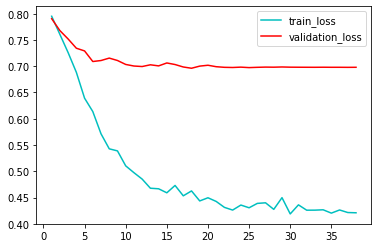

In [ ]:
#Plot of training loss and validation loss w.r.t. epochs (in a single figure)
length = len(train_loss_epoch)
X = np.linspace(1,length,length)
Y1 = train_loss_epoch
Y2 = val_loss_epoch
plt.plot(X, Y1, label = 'train_loss', color = 'c')
plt.legend()
plt.plot(X, Y2, label = 'validation_loss', color = 'r')
plt.legend()
plt.show()

In [20]:
# for i, (img, target) in enumerate(train_dataloader):
#     if gpu_boole:
#         img, target = img.cuda(), target.cuda()
#     if i == 0:
#         inputs1 = img
#         targets1 = target
#         break

# torch.cuda.empty_cache()
# outputs1 = model(inputs1)
# preds1 = torch.argmax(outputs1, dim=1)
# pic = 32 * preds1[0] / 255
# pic = pic.cpu()
# pic = pic.numpy()
# # print(pic.shape)
# plt.imshow(pic, cmap=plt.cm.gray)
# plt.show()

# 1(b)

## Data Augmentation

In [ ]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 100

In [ ]:
img_transform_0 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1),
])

## Initialize your unet
n_classes = 8   #number of classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNET(n_classes)
model = model.to(device)
loss_fn = DICELoss()

## Initialize Dataloaders
# train_dataset_0=TrainImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json)
# train_dataset_0 = torch.rand(250,320,3)
# train_dataset_0 = train_dataset_0.permute(2,0,1)
# train_dataset_1=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform_1)

train_dataset_0=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform_0)
train_dataset_2=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
train_dataset=torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_2])

validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
# dataiter = iter(train_dataloader)
# images, targets = dataiter.next()
# print(type(images))
# print(images.shape)
# print(targets.shape)

<class 'torch.Tensor'>
torch.Size([10, 3, 256, 320])
torch.Size([10, 8, 256, 320])


In [ ]:
###########double the dataset
#Training and Validation
train_loss = []
train_loss_epoch = []
val_loss = []
val_loss_epoch = []

train_score = []
val_score = []

early_stopping = EarlyStopping(patience=20, verbose=True)

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    if gpu_boole:
        torch.cuda.empty_cache

    model.train()
    for i, (img, target) in enumerate(train_dataloader):
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        prediction = model(img)
        tloss = loss_fn(prediction, target)
        train_loss.append(tloss.item())
        tloss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_train_loss = np.mean(train_loss)
    train_loss_epoch.append(mean_train_loss)
    print('The training loss is:', mean_train_loss)
    scheduler.step()

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    for img, target in validation_dataloader:
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        prediction = model(img)
        vloss = loss_fn(prediction, target)
        val_loss.append(vloss.item())
        vloss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_val_loss = np.mean(val_loss)
    val_loss_epoch.append(mean_val_loss)
    print('The validation loss is:', mean_val_loss)
    scheduler.step()

    # clear lists to track next epoch
    train_loss = []
    val_loss = []

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(mean_val_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

Start Training...

EPOCH 1 of 100

The training loss is: 0.7722178136430576
The validation loss is: 0.7587309173451242
Validation loss decreased (inf --> 0.758731).  Saving model ...

EPOCH 2 of 100

The training loss is: 0.6980044321899166
The validation loss is: 0.791865967425649
EarlyStopping counter: 1 out of 20

EPOCH 3 of 100

The training loss is: 0.6257303408229331
The validation loss is: 0.7644127938385316
EarlyStopping counter: 2 out of 20

EPOCH 4 of 100

The training loss is: 0.5880970735586755
The validation loss is: 0.7410051968053286
Validation loss decreased (0.758731 --> 0.741005).  Saving model ...

EPOCH 5 of 100

The training loss is: 0.554658904055094
The validation loss is: 0.7041097963313605
Validation loss decreased (0.741005 --> 0.704110).  Saving model ...

EPOCH 6 of 100

The training loss is: 0.5404086478502488
The validation loss is: 0.6999201816948875
Validation loss decreased (0.704110 --> 0.699920).  Saving model ...

EPOCH 7 of 100

The training loss is

In [ ]:
#Report performance (DICE score) on the test dataset (expect DICE score > 0.6)
if gpu_boole:
    torch.cuda.empty_cache
test_scores = []
test_scores.append(dice_score_dataset(model, test_dataloader, n_classes, True))
print("test score:", test_scores[0])

test score: 0.6584078436134155


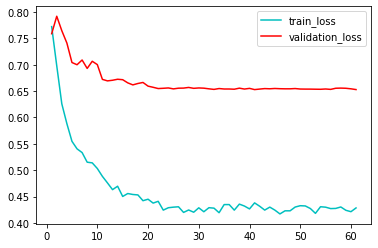

In [ ]:
#Plot of training loss and validation loss w.r.t. epochs (in a single figure)
length = len(train_loss_epoch)
X = np.linspace(1,length,length)
Y1 = train_loss_epoch
Y2 = val_loss_epoch
plt.plot(X, Y1, label = 'train_loss', color = 'c')
plt.legend()
plt.plot(X, Y2, label = 'validation_loss', color = 'r')
plt.legend()
plt.show()

In [19]:
# for i, (img, target) in enumerate(train_dataloader):
#     if gpu_boole:
#         img, target = img.cuda(), target.cuda()
#     if i == 0:
#         inputs1 = img
#         targets1 = target
#         break

# torch.cuda.empty_cache()
# outputs1 = model(inputs1)
# preds1 = torch.argmax(outputs1, dim=1)
# pic = 32 * preds1[0] / 255
# pic = pic.cpu()
# pic = pic.numpy()
# # print(pic.shape)
# plt.imshow(pic, cmap=plt.cm.gray)
# plt.show()

# 1(c)

## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

In [9]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                #  mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        # with open(mask_json_path, 'r') as f:
        #     self.mask = json.load(f)
        # self.mask_num = len(self.mask)  # There are 8 categories: grey, dark grey, and black
        # self.mask_value = [value for value in self.mask.values()]
        # self.mask_value.sort()
        try:
            if self.op == 'train_cor':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'validation_cor':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train_cor or validation_cor')

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """
        
        """
        ## Load Image and Parse Properties
        img_name = str(idx) + '_gray.jpg'
        mask_name = str(idx) + '_input.jpg'

        #The images are transformed into NumPy array
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        
        ## Transform image and mask
        if self.transform:
            img, mask = self.img_transform(img, mask)
        # ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """
        
        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)

        return img, mask

In [10]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET_COR(nn.Module):
    
    """
    
    """
    def __init__(self,n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        super(UNET_COR, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(1, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        #8 categories
        self.out = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size = 1),  #RGB - 3 channels
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        out = self.out(conv1m_out)
        return out

In [11]:
## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=colorization_data_dir, op="train_cor", transforms=img_transform)
validation_dataset=ImageDataset(input_dir=colorization_data_dir, op="validation_cor", transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)

n_classes = 8
model_path = " "
model = UNET_COR(n_classes)
if gpu_boole:
    model.cuda()
loss_fn = nn.MSELoss()

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [14]:
#Training and Validation
train_loss = []
train_loss_epoch = []
val_loss = []
val_loss_epoch = []

train_score = []
val_score = []

early_stopping = EarlyStopping(patience=20, verbose=True)

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    if gpu_boole:
        torch.cuda.empty_cache

    model.train()
    for i, (img, target) in enumerate(train_dataloader):
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        prediction = model(img)
        tloss = loss_fn(prediction, target)
        train_loss.append(tloss.item())
        tloss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_train_loss = np.mean(train_loss)
    train_loss_epoch.append(mean_train_loss)
    print('The training loss is:', mean_train_loss)
    scheduler.step()

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    for img, target in validation_dataloader:
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        prediction = model(img)
        vloss = loss_fn(prediction, target)
        val_loss.append(vloss.item())
        vloss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_val_loss = np.mean(val_loss)
    val_loss_epoch.append(mean_val_loss)
    print('The validation loss is:', mean_val_loss)
    scheduler.step()

    # clear lists to track next epoch
    train_loss = []
    val_loss = []

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(mean_val_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

Start Training...

EPOCH 1 of 200

The training loss is: 0.03779041748376762
The validation loss is: 0.02102474942803383
Validation loss decreased (inf --> 0.021025).  Saving model ...

EPOCH 2 of 200

The training loss is: 0.017974542360167083
The validation loss is: 0.013185200840234756
Validation loss decreased (0.021025 --> 0.013185).  Saving model ...

EPOCH 3 of 200

The training loss is: 0.011538262115850014
The validation loss is: 0.009301223792135715
Validation loss decreased (0.013185 --> 0.009301).  Saving model ...

EPOCH 4 of 200

The training loss is: 0.008283745992413294
The validation loss is: 0.007338901702314615
Validation loss decreased (0.009301 --> 0.007339).  Saving model ...

EPOCH 5 of 200

The training loss is: 0.006422654845687391
The validation loss is: 0.006150405388325453
Validation loss decreased (0.007339 --> 0.006150).  Saving model ...

EPOCH 6 of 200

The training loss is: 0.005202855783040231
The validation loss is: 0.005191696807742119
Validation los

In [15]:
torch.save(model.state_dict(), model_path)

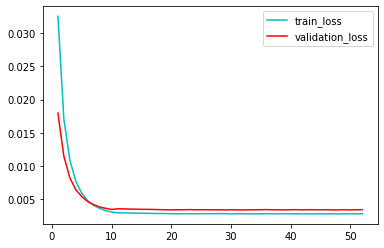

In [ ]:
#Plot of training loss and validation loss w.r.t. epochs (in a single figure)
length = len(train_loss_epoch)
X = np.linspace(1,length,length)
Y1 = train_loss_epoch
Y2 = val_loss_epoch
plt.plot(X, Y1, label = 'train_loss', color = 'c')
plt.legend()
plt.plot(X, Y2, label = 'validation_loss', color = 'r')
plt.legend()
plt.show()

# 1(d)

In [21]:
# n_classes = 8   #number of classes
# model = UNET(n_classes)
# if gpu_boole:
#     model.cuda()
# loss_fn = nn.MSELoss()

# #Load pretrained model
# save_model = torch.load(model_path)
# model_dict = model.state_dict()
# state_dict = {k:v for k,v in save_model.items() if k in model_dict.keys()}
# model_dict.update(state_dict)
# model.load_state_dict(model_dict)

# ## Initialize Dataloaders
# train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
# validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
# test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)

# train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
# validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ## Initialize Optimizer and Learning Rate Scheduler
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
train_loss = []
train_loss_epoch = []
val_loss = []
val_loss_epoch = []

train_score = []
val_score = []

early_stopping = EarlyStopping(patience=20, verbose=True)

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    if gpu_boole:
        torch.cuda.empty_cache

    model.train()
    for i, (img, target) in enumerate(train_dataloader):
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        prediction = model(img)
        tloss = loss_fn(prediction, target)
        train_loss.append(tloss.item())
        tloss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_train_loss = np.mean(train_loss)
    train_loss_epoch.append(mean_train_loss)
    print('The training loss is:', mean_train_loss)
    scheduler.step()

    ########################### Validation #####################################
    # TODO: Design your own validation section
    for i, (img, target) in enumerate(validation_dataloader):
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        prediction = model(img)
        vloss = loss_fn(prediction, target)
        val_loss.append(vloss.item())
    mean_val_loss = np.mean(val_loss)
    val_loss_epoch.append(mean_val_loss)
    print('The validation loss is:', mean_val_loss)
    scheduler.step()

    # clear lists to track next epoch
    train_loss = []
    val_loss = []

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    
    early_stopping(mean_val_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Problem 2: Transfer Learning

### Imports

In [ ]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

gpu_boole = torch.cuda.is_available()

In [ ]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

### Data Loading

In [ ]:
## Specify Batch Size
train_batch_size = 32
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# dataiter = iter(training_dataloader)
# images, targets = dataiter.next()
# print(type(images))
# print(images.shape)
# print(targets.shape)

<class 'torch.Tensor'>
torch.Size([32, 1, 64, 64])
torch.Size([32])


In [ ]:
# dataiter = iter(test_dataloader)
# images, targets = dataiter.next()
# print(type(images))
# print(images.shape)
# print(targets.shape)

<class 'torch.Tensor'>
torch.Size([32, 3, 256, 320])
torch.Size([32, 8, 256, 320])


### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

(a) Randomly initialize all parameters in VGG16 and try to train your model to learn the
Fashion MNIST classification task. What’s the accuracy you achieve? Please report
your test accuracy on the test dataset. You should expect an accuracy > 85%

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = vgg16(pretrained = False)
model.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [ ]:
#Accuracy
def acc(dataloader, batch_size): 
    cnt = 0
    for img, target in dataloader: 
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        # outputs = model(img)
        outputs = functional.log_softmax(model(img), dim=1)
        pred = outputs.argmax(dim=1,keepdim=True)
        cnt += pred.eq(target.view_as(pred)).sum().item()
    size = len(dataloader)*batch_size
    acc = 100 * cnt / size
    return acc
        

In [ ]:
num_epochs = 5
train_loss = []
train_loss_epoch = []
test_acc_epoch = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model.train()
    for i, (img, target) in enumerate(training_dataloader):
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        # prediction = model(img)
        prediction = functional.log_softmax(model(img), dim=1)
        tloss = loss_fn(prediction, target)
        train_loss.append(tloss.item())
        tloss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_train_loss = np.mean(train_loss)
    print('Training loss:', mean_train_loss) 
    train_loss_epoch.append(mean_train_loss)
    train_loss = []

    ########################### Testing #####################################
    test_acc = acc(test_dataloader, test_batch_size)
    test_acc_epoch.append(test_acc)
    print('Testing accuracy: %f %%' % test_acc) 

    

Start Training...

EPOCH 1 of 5

Training loss: 0.7102172535101573
Testing accuracy: 80.800719 %

EPOCH 2 of 5

Training loss: 0.35857486230333646
Testing accuracy: 86.781150 %

EPOCH 3 of 5

Training loss: 0.29409675292770066
Testing accuracy: 88.388578 %

EPOCH 4 of 5

Training loss: 0.25730950597723323
Testing accuracy: 89.227236 %

EPOCH 5 of 5

Training loss: 0.22792976094782352
Testing accuracy: 90.764776 %


(b) Load the pre-trained VGG16 model from torch vision models. Freeze all but the last
layer: randomly initialize the last layer of your network and fine-tune this. What
accuracy do you get now? Please again report your test accuracy on the test dataset.
You should expect an accuracy > 60%.

In [ ]:
model = vgg16(pretrained = True)
model.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

loss_fn = nn.NLLLoss()
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),lr=0.01)

#freeze all layers but the last
for layer in model.features[:-1]:
    for param in layer.parameters():
        param.require_grad = False

for layer in model.classifier[:-1]:
    for param in layer.parameters():
        param.require_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
#randomly initialize the last layer

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_epochs = 5
train_loss = []
train_loss_epoch = []
test_acc_epoch = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model.train()
    for i, (img, target) in enumerate(training_dataloader):
        if gpu_boole:
            img, target = img.cuda(), target.cuda()
        # prediction = model(img)
        prediction = functional.log_softmax(model(img), dim=1)
        tloss = loss_fn(prediction, target)
        train_loss.append(tloss.item())
        tloss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_train_loss = np.mean(train_loss)
    print('Training loss:', mean_train_loss)
    train_loss_epoch.append(mean_train_loss)
    train_loss = []

    ########################### Testing #####################################
    test_acc = acc(test_dataloader, test_batch_size)
    test_acc_epoch.append(test_acc)
    print('Testing accuracy: %f %%' % test_acc) 

Start Training...

EPOCH 1 of 5

Training loss: 0.3827867922842503
Testing accuracy: 88.128994 %

EPOCH 2 of 5

Training loss: 0.23608014727433524
Testing accuracy: 90.435304 %

EPOCH 3 of 5

Training loss: 0.19614598174244166
Testing accuracy: 92.482029 %

EPOCH 4 of 5

Training loss: 0.1647636582604299
Testing accuracy: 92.721645 %

EPOCH 5 of 5

Training loss: 0.14099121207743884
Testing accuracy: 92.222444 %


(c) Now, imagine a scenario in which you want to train the VGG16 model on an entirely
new dataset and will fine-tune either the model from (2a) or (2b). Which pre-trained
model is the preferred starting point for your new use case?